 ## linear svm：
对训练样本（Xi，yi）,其对应每个类别的得分为：

　　score = W*Xi+ b

是长度为C的矢量，以s表示 score， s = [s1, s2, s3, ..., sC] = [W1*Xi,  W2*Xi, W3*Xi, ..., WC*Xi]

Xi对应的损失(hinge loss)：

　　loss[i] = ∑j≠yi max（0，sj - syi + delta）

总的损失，加入正则化项 R(W)：

　　 loss = (1/N)*ΣNi=1 loss[i] + R(W) = (1/N)*ΣNi=1 ∑j≠yi max（0，sj - syi + delta）+  λ*Σi Σj Wi,j2

　　loss[i] = -∑log( p*h) =  -∑Cj=1 log(pj*hj)= -log(hyi) 

总的损失，加入正则化项 R(W)：

　　loss =  (1/N)* ΣNi=1 loss[i]  + R(W)  =   -(1/N)*ΣNi=1 log{ exp(syi) / ΣNk=1 exp(sk) } +  λ*Σi Σj Wi,j2

In [ ]:
def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[np.arange(N), y]
  margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  num_pos = np.sum(margins > 0, axis=1)
  dx = np.zeros_like(x)
  dx[margins > 0] = 1
  dx[np.arange(N), y] -= num_pos
  dx /= N
  return loss, dx

 ## softmax:
对训练样本（Xi，yi）, 利用 yi 构造长度为C的矢量 p = [0, 0, 0, ..., 1, ...]，第 yi 位置为 1，其余为 0，

先计算每个类别的得分：

　　score = W*Xi+ b ，与上同

但是softmax继续对得分进行 归一化处理，得到 Xi 在每个类别的概率：

　　h = exp(s) / Σexp(s)，

即有 h = [h1, h2, ..., hC]，hj = exp(sj) / ΣCk=1 exp(sk)

Xi对应的损失(交叉熵损失 cross-entropy loss)：

　　loss[i] = -∑log( p*h) =  -∑Cj=1 log(pj*hj)= -log(hyi) 

总的损失，加入正则化项 R(W)：

　　loss =  (1/N)* ΣNi=1 loss[i]  + R(W)  =   -(1/N)*ΣNi=1 log{ exp(syi) / ΣNk=1 exp(sk) } +  λ*Σi Σj Wi,j2

In [ ]:
def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx

## softmax 梯度计算：
 对 loss 关于 w 进行求导即可得到梯度∂L/∂wj ，w = [w1, w2, w3, ... , wC]，wj 是 Dx1的列向量

∂L / ∂wj = -(1/N) * ΣNi=1 Xi*[ 1{yi=j} - hj ] 

 梯度方向即是，w沿着梯度变化时，loss值变化最快的方向。利用梯度对loss进行优化，

（求w）从而最小化    loss

利用SGD训练
W := W - ∂L / ∂wj 

算法程序：

1. 随机初始化 w

2. 迭代（ 一定次数 或者 前后两次迭代是 loss 差值小于阈值 ）

repeat {

　　2.1 计算 loss，计算梯度∂L / ∂wj 

　　2.2 更新w

　　　　w := w - 2. 计算梯度∂L / ∂wj 

}

## Multiclass SVM Loss
给出 （xi,yi） ，其中 xi 是图像，yi 是图像的类别（整数），s=f（xi,W），其中s 是网络的输出，则定义误差如下： 
Li=∑j≠yimax(0,sj−syi+1)

例如s=[3,2,5],yi=0,那么Li=max(0,2−3+1)+max(0,5−3+1)=3

In [21]:
#liner classifier
import numpy as np
from cs231n.classifiers.linear_svm import *
from cs231n.classifiers.softmax import *

class LinearClassifier:

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        dim, num_train = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = np.random.randn(num_classes, dim) * 0.001

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
      X_batch = None
      y_batch = None

      sample_index = np.random.choice(num_train, batch_size, replace=False)
      X_batch = X[:,sample_index]
      y_batch = y[sample_index]

      # y_batch = np.random.choice(y,batch_size,replace=False)
      # X_batch = X[:,y_batch]
      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
      # evaluate weight with using loss and gradient
      self.W += -learning_rate * grad

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

    def predict(self, X):
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(np.dot(self.W,X),axis=0)

    return y_pred
  
    def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: D x N array of data; each column is a data point.
    - y_batch: 1-dimensional array of length N with labels 0...K-1, for K classes.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


    class Softmax(LinearClassifier):
   # """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



IndentationError: expected an indented block (<ipython-input-21-59b0a48aa835>, line 61)

In [23]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [35]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
#print(X_train)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


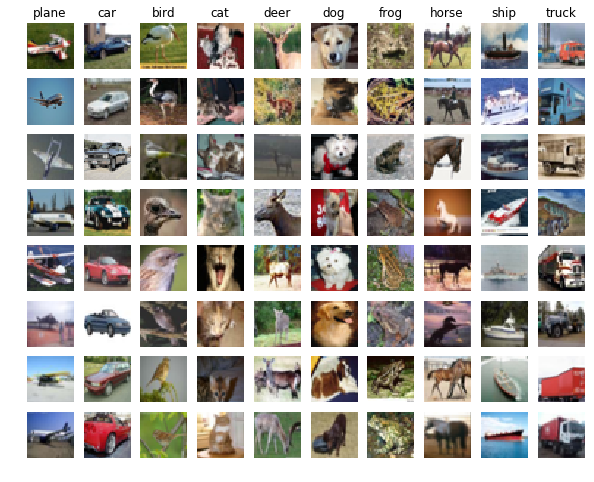

In [36]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 8
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [37]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
#range?
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
np.random.choice?
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [39]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


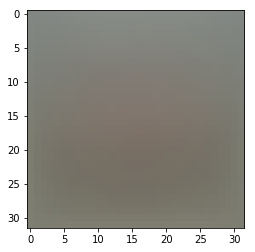

In [40]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [42]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)


(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [43]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.706650


In [44]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.503143 analytic: 0.000000, relative error: 1.000000e+00
numerical: 5.105074 analytic: 0.000000, relative error: 1.000000e+00
numerical: -11.207232 analytic: 0.000000, relative error: 1.000000e+00
numerical: 2.238671 analytic: 0.000000, relative error: 1.000000e+00
numerical: 2.056738 analytic: 0.000000, relative error: 1.000000e+00
numerical: 19.908966 analytic: 0.000000, relative error: 1.000000e+00
numerical: -26.969708 analytic: 0.000000, relative error: 1.000000e+00
numerical: -6.304815 analytic: 0.000000, relative error: 1.000000e+00
numerical: 12.611117 analytic: 0.000000, relative error: 1.000000e+00
numerical: 12.308423 analytic: 0.000000, relative error: 1.000000e+00
numerical: 7.912469 analytic: 0.000000, relative error: 1.000000e+00
numerical: 8.135897 analytic: 0.000000, relative error: 1.000000e+00
numerical: -34.642042 analytic: 0.000000, relative error: 1.000000e+00
numerical: 5.849652 analytic: 0.000000, relative error: 1.000000e+00
numerical: 2.947018 anal

In [38]:
#https://blog.csdn.net/pjia_1008/article/details/66972060
#https://blog.csdn.net/pjia_1008/article/details/66972060